In [89]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import haversine_distances
from math import radians, cos, sin, asin, sqrt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error, r2_score

In [101]:
df = pd.read_csv('training.csv')
df.head()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0.002653,s
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,2.233584,b
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,2.347389,b
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,5.446378,b
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,6.245333,b


# Missing value handling

In [102]:
# No. of missing value(-999.000000) in each column
df = df[(df != -999.000000)]
print(df.isnull().sum())

EventId                             0
DER_mass_MMC                    38114
DER_mass_transverse_met_lep         0
DER_mass_vis                        0
DER_pt_h                            0
DER_deltaeta_jet_jet           177457
DER_mass_jet_jet               177457
DER_prodeta_jet_jet            177457
DER_deltar_tau_lep                  0
DER_pt_tot                          0
DER_sum_pt                          0
DER_pt_ratio_lep_tau                0
DER_met_phi_centrality              0
DER_lep_eta_centrality         177457
PRI_tau_pt                          0
PRI_tau_eta                         0
PRI_tau_phi                         0
PRI_lep_pt                          0
PRI_lep_eta                         0
PRI_lep_phi                         0
PRI_met                             0
PRI_met_phi                         0
PRI_met_sumet                       0
PRI_jet_num                         0
PRI_jet_leading_pt              99913
PRI_jet_leading_eta             99913
PRI_jet_lead

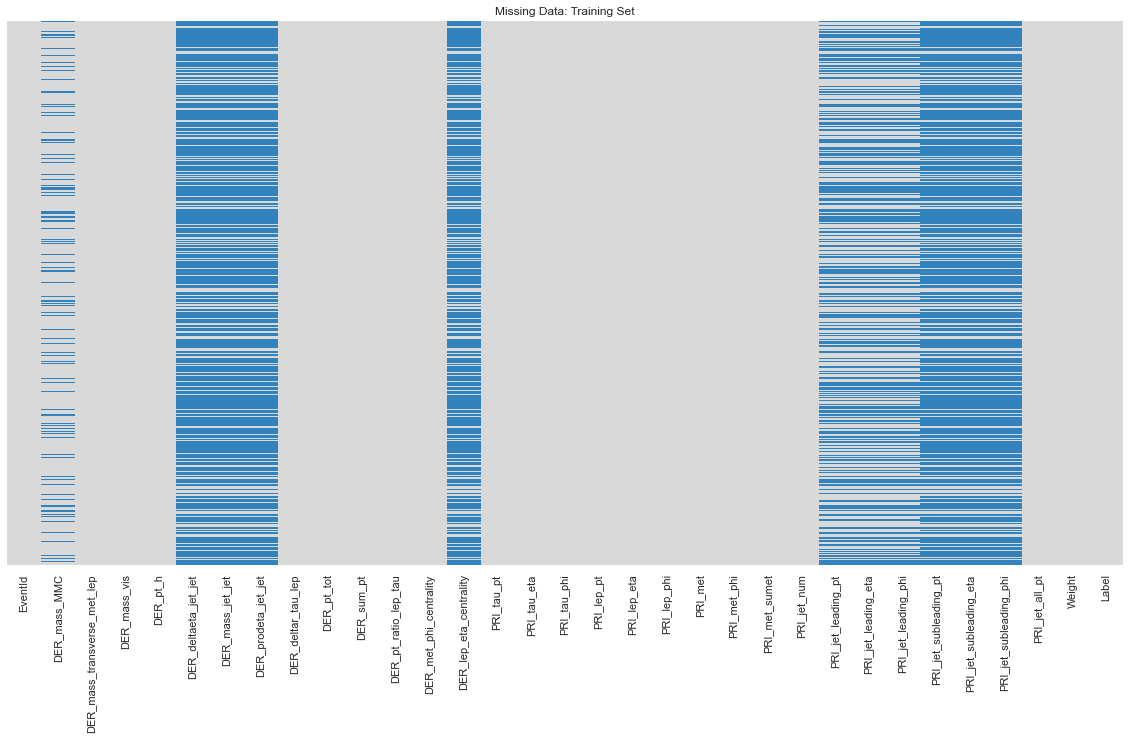

In [103]:
plt.figure(figsize =(20,10))
sns.heatmap(df.isnull(),yticklabels = False, cbar = False,cmap = 'tab20c_r')
plt.title('Missing Data: Training Set')
plt.show()

In [104]:
# No. of columns = 33
# Target: 'Label'
# Total no of rows/data points/records: 250000
columns = ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 
            'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 
            'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_tau_pt', 
            'PRI_tau_eta, PRI_tau_phi', 'PRI_lep_pt, PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi', 
            'PRI_met_sumet, PRI_jet_num', 'PRI_jet_leading_pt', 'PRI_jet_leading_eta', 'PRI_jet_leading_phi',
            'PRI_jet_subleading_pt', 'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt, Weight', 'Label']

# no of miss values in below columns: 177457 (70% rows of all rows)
features_with_missValue = ['PRI_jet_subleading_pt', 'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi',
                           'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_lep_eta_centrality']

# no of miss values in below columns:  99913 (aprx. 40% rows of all rows)
features_with_missValue2 = ['PRI_jet_leading_pt', 'PRI_jet_leading_eta', 'PRI_jet_leading_phi']

# no of miss values in below columns: 38114 (aprx. 15% of all rows)
features_with_missValue3 = ['DER_mass_MMC']

# Since significance no. of values is missing in column set features_with_missValue, features_with_missValue2
# So removing those columns from feature set. (dataframe).
print(df.shape)

df = df.drop(columns = features_with_missValue, axis=1)
df.reset_index(drop = True, inplace = True)

df = df.drop(columns = features_with_missValue2, axis=1)
df.reset_index(drop = True, inplace = True)

print(df.shape)

# removing records, those having missing values.
#df = df.dropna(axis=0)
#df.reset_index(drop = True, inplace = True)

# replacing null with mean of DER_mass_MMC
df['DER_mass_MMC'].fillna(df['DER_mass_MMC'].mean(), inplace=True)
print(df.shape)

(250000, 33)
(250000, 23)
(250000, 23)


In [105]:
df.drop(labels=['EventId'], axis = 1, inplace = True )
df.reset_index(drop = True, inplace = True)
df.describe()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,PRI_tau_pt,...,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_all_pt,Weight
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,...,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000
mean,121.858528,49.239819,81.181982,57.895962,2.373100,18.917332,158.432217,1.437609,-0.128305,38.707419,...,-0.008171,46.660207,-0.019507,0.043543,41.717235,-0.010119,209.797178,0.979176,73.064591,1.646767
std,52.749898,35.344886,40.828691,63.655682,0.782911,22.273494,115.706115,0.844743,1.193585,22.412081,...,1.816763,22.064922,1.264982,1.816611,32.894693,1.812223,126.499506,0.977426,98.015662,1.875103
min,9.044000,0.000000,6.329000,0.000000,0.208000,0.000000,46.104000,0.047000,-1.414000,20.000000,...,-3.142000,26.000000,-2.505000,-3.142000,0.109000,-3.142000,13.678000,0.000000,0.000000,0.001502
25%,95.665000,19.241000,59.388750,14.068750,1.810000,2.841000,77.550000,0.883000,-1.371000,24.591750,...,-1.575000,32.375000,-1.014000,-1.522000,21.398000,-1.575000,123.017500,0.000000,0.000000,0.018636
50%,119.958000,46.524000,73.752000,38.467500,2.491500,12.315500,120.664500,1.280000,-0.356000,31.804000,...,-0.033000,40.516000,-0.045000,0.086000,34.802000,-0.024000,179.739000,1.000000,40.512500,1.156188
75%,130.606250,73.598000,92.259000,79.169000,2.961000,27.591000,200.478250,1.777000,1.225000,45.017000,...,1.565000,53.390000,0.959000,1.618000,51.895000,1.561000,263.379250,2.000000,109.933750,2.404128
max,1192.026000,690.075000,1349.351000,2834.999000,5.684000,2834.999000,1852.462000,19.773000,1.414000,764.408000,...,3.142000,560.271000,2.503000,3.142000,2842.617000,3.142000,2003.976000,3.000000,1633.433000,7.822543


In [106]:
df.nunique()

DER_mass_MMC                   108338
DER_mass_transverse_met_lep    101637
DER_mass_vis                   100558
DER_pt_h                       115563
DER_deltar_tau_lep               4692
DER_pt_tot                      59042
DER_sum_pt                     156098
DER_pt_ratio_lep_tau             5931
DER_met_phi_centrality           2829
PRI_tau_pt                      59639
PRI_tau_eta                      4971
PRI_tau_phi                      6285
PRI_lep_pt                      61929
PRI_lep_eta                      4987
PRI_lep_phi                      6285
PRI_met                         87836
PRI_met_phi                      6285
PRI_met_sumet                  179740
PRI_jet_num                         4
PRI_jet_all_pt                 103559
Weight                         104096
Label                               2
dtype: int64

In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 22 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   DER_mass_MMC                 250000 non-null  float64
 1   DER_mass_transverse_met_lep  250000 non-null  float64
 2   DER_mass_vis                 250000 non-null  float64
 3   DER_pt_h                     250000 non-null  float64
 4   DER_deltar_tau_lep           250000 non-null  float64
 5   DER_pt_tot                   250000 non-null  float64
 6   DER_sum_pt                   250000 non-null  float64
 7   DER_pt_ratio_lep_tau         250000 non-null  float64
 8   DER_met_phi_centrality       250000 non-null  float64
 9   PRI_tau_pt                   250000 non-null  float64
 10  PRI_tau_eta                  250000 non-null  float64
 11  PRI_tau_phi                  250000 non-null  float64
 12  PRI_lep_pt                   250000 non-null  float64
 13 

In [108]:
# Skew for each attribute
skew = df.skew()
print(skew)

DER_mass_MMC                    4.135626
DER_mass_transverse_met_lep     1.219211
DER_mass_vis                    3.790262
DER_pt_h                        2.541885
DER_deltar_tau_lep             -0.215782
DER_pt_tot                     10.579309
DER_sum_pt                      2.320647
DER_pt_ratio_lep_tau            2.633521
DER_met_phi_centrality          0.151136
PRI_tau_pt                      3.755191
PRI_tau_eta                     0.017852
PRI_tau_phi                     0.013872
PRI_lep_pt                      3.240762
PRI_lep_eta                     0.021623
PRI_lep_phi                    -0.045746
PRI_met                         5.270755
PRI_met_phi                     0.007908
PRI_met_sumet                   1.849445
PRI_jet_num                     0.611280
PRI_jet_all_pt                  2.379556
Weight                          0.990633
dtype: float64


C:\Users\kaush\AppData\Local\Temp/ipykernel_8896/118809556.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  skew = df.skew()


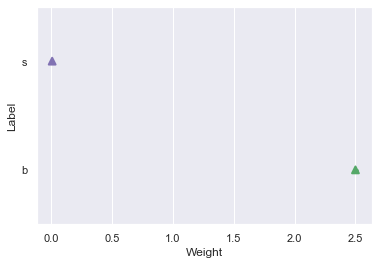

In [109]:
sns.pointplot(x="Weight", y="Label", data=df, palette={"b":"g","s":"m"}, markers=["^","o"], linestyles=["-","--"])
plt.show()

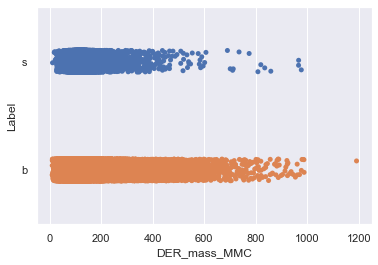

In [110]:
sns.stripplot(x="DER_mass_MMC", y="Label", data=df)
plt.show()

In [111]:
df.DER_mass_MMC.value_counts()

121.858528    38114
108.914000       10
96.819000        10
103.762000       10
108.957000       10
              ...  
47.910000         1
274.769000        1
191.831000        1
200.830000        1
217.020000        1
Name: DER_mass_MMC, Length: 108338, dtype: int64

In [112]:
df.DER_mass_transverse_met_lep.value_counts()

1.800      13
9.362      12
3.501      12
2.500      12
3.183      12
           ..
20.637      1
126.732     1
18.280      1
71.255      1
19.362      1
Name: DER_mass_transverse_met_lep, Length: 101637, dtype: int64

In [113]:
df.DER_mass_vis.value_counts()

76.819     16
61.286     15
70.412     14
76.629     13
71.097     13
           ..
110.242     1
431.917     1
194.393     1
107.121     1
75.839      1
Name: DER_mass_vis, Length: 100558, dtype: int64

In [114]:
df.DER_pt_h.value_counts()

0.000      41
1.843      25
0.697      25
0.778      25
1.308      25
           ..
63.439      1
317.840     1
204.565     1
89.779      1
127.953     1
Name: DER_pt_h, Length: 115563, dtype: int64

In [115]:
df.DER_deltar_tau_lep.value_counts()

3.094    202
3.131    201
3.078    199
3.117    197
2.904    194
        ... 
5.111      1
4.827      1
5.291      1
5.346      1
4.846      1
Name: DER_deltar_tau_lep, Length: 4692, dtype: int64

In [116]:
df.DER_pt_tot.value_counts()

1.072     44
0.964     43
1.282     43
0.851     41
1.308     41
          ..
68.227     1
72.535     1
64.868     1
70.364     1
48.742     1
Name: DER_pt_tot, Length: 59042, dtype: int64

In [117]:
df.DER_sum_pt.value_counts()

76.854     13
68.481     12
64.523     11
64.673     10
69.800     10
           ..
90.987      1
353.362     1
166.115     1
142.387     1
55.892      1
Name: DER_sum_pt, Length: 156098, dtype: int64

In [118]:
df.DER_pt_ratio_lep_tau.value_counts()

0.901    206
1.128    198
1.232    197
0.954    196
1.249    195
        ... 
8.287      1
4.918      1
5.143      1
4.565      1
6.579      1
Name: DER_pt_ratio_lep_tau, Length: 5931, dtype: int64

In [119]:
df.DER_met_phi_centrality.value_counts()

-1.414    11429
 1.414     7778
-1.413     5227
-1.412     3514
 1.413     3345
          ...  
-0.273       12
-0.353       11
-0.295       11
 0.471       10
 0.287       10
Name: DER_met_phi_centrality, Length: 2829, dtype: int64

In [125]:
df.PRI_tau_pt.value_counts()

21.134     32
20.059     30
20.048     29
20.195     29
22.257     29
           ..
48.172      1
119.773     1
112.918     1
72.726      1
298.035     1
Name: PRI_tau_pt, Length: 59639, dtype: int64

In [126]:
df.PRI_tau_eta.value_counts()

 0.152    141
-0.152    131
-0.301    129
-0.899    124
 0.300    122
         ... 
 2.488      1
 2.491      1
 2.495      1
 2.493      1
-2.489      1
Name: PRI_tau_eta, Length: 4971, dtype: int64

In [127]:
df.PRI_tau_phi.value_counts()

-2.988    72
-1.235    69
-0.542    66
-2.017    66
-0.540    65
          ..
-3.052    18
 0.280    18
 2.164    18
 3.142     5
-3.142     4
Name: PRI_tau_phi, Length: 6285, dtype: int64

In [128]:
df.PRI_lep_pt.value_counts()

28.855     22
30.037     22
28.329     22
28.580     22
32.806     21
           ..
93.823      1
55.821      1
66.589      1
110.985     1
95.570      1
Name: PRI_lep_pt, Length: 61929, dtype: int64

In [129]:
df.PRI_lep_eta.value_counts()

 0.307    106
-0.206    105
 0.392     95
-0.629     94
 0.364     94
         ... 
-2.505      1
 2.492      1
-2.482      1
 2.491      1
 2.493      1
Name: PRI_lep_eta, Length: 4987, dtype: int64

In [130]:
df.PRI_lep_phi.value_counts()

 3.050    64
 1.606    64
 1.917    64
-0.171    63
 0.086    62
          ..
-0.050    16
-1.316    16
-1.075    14
-3.142     9
 3.142     2
Name: PRI_lep_phi, Length: 6285, dtype: int64

In [131]:
df.PRI_met.value_counts()

31.252     15
31.701     14
27.915     13
26.642     13
15.307     13
           ..
67.080      1
118.441     1
93.020      1
70.741      1
97.737      1
Name: PRI_met, Length: 87836, dtype: int64

In [132]:
df.PRI_met_phi.value_counts()

-2.091    66
-2.063    65
 1.600    64
-2.911    64
 0.516    63
          ..
 1.946    20
 1.362    20
-0.966    19
 3.142     6
-3.142     3
Name: PRI_met_phi, Length: 6285, dtype: int64

In [133]:
df.PRI_met_sumet.value_counts()

166.606    8
151.000    7
170.273    7
161.331    7
172.094    7
          ..
103.095    1
54.816     1
142.932    1
46.396     1
99.405     1
Name: PRI_met_sumet, Length: 179740, dtype: int64

In [134]:
df.PRI_jet_num.value_counts()

0    99913
1    77544
2    50379
3    22164
Name: PRI_jet_num, dtype: int64

In [135]:
df.PRI_jet_all_pt.value_counts()

-0.000      99913
 30.763        10
 36.358        10
 30.363        10
 36.493        10
            ...  
 112.756        1
 111.886        1
 222.618        1
 121.216        1
 174.176        1
Name: PRI_jet_all_pt, Length: 103559, dtype: int64

In [136]:
df.Weight.value_counts()

0.001503    38552
0.018636    32352
1.681611    17259
0.744056    10351
0.002653     7789
            ...  
2.807358        1
5.430880        1
2.311713        1
2.115398        1
1.877474        1
Name: Weight, Length: 104096, dtype: int64

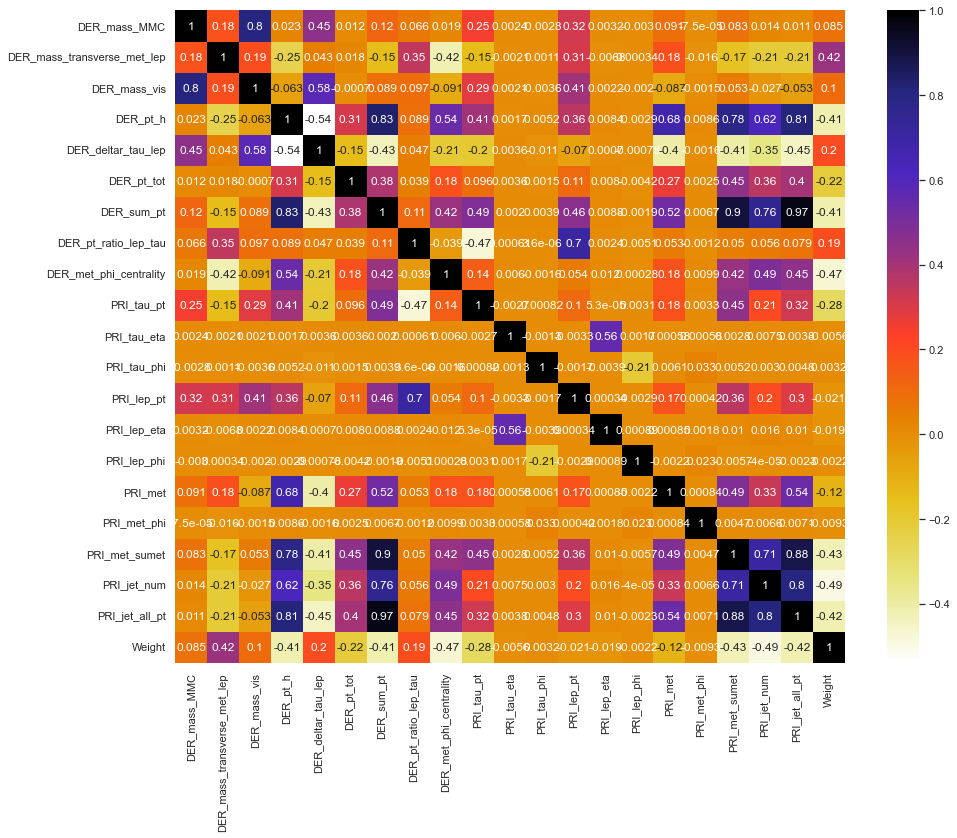

In [137]:
# Correlation matrix
plt.figure(figsize=(15,12))
sns.set()
sns.heatmap(df.corr(), annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

Target Variable
Label
b    164333
s     85667
Name: Label, dtype: int64


C:\Users\kaush\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


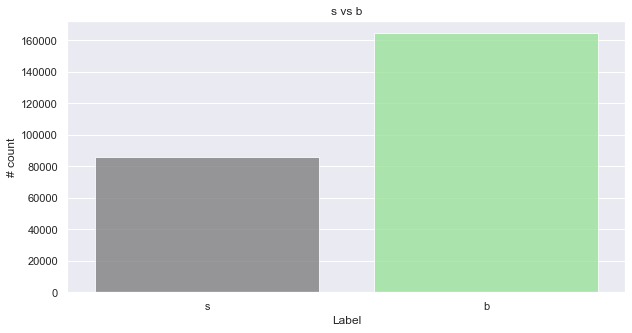

In [138]:
print('Target Variable')
print(df.groupby(['Label']).Label.count())

# Target Variable Countplot
sns.set_style('darkgrid')
plt.figure(figsize = (10,5))
sns.countplot(df['Label'], alpha =.80, palette= ['grey','lightgreen'])
plt.title('s vs b')
plt.ylabel('# count')
plt.show()

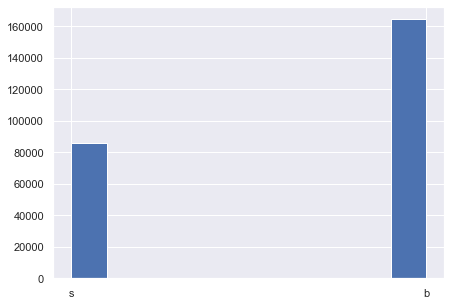

In [139]:
plt.figure(figsize =(7,5))
x = df['Label']
plt.hist(x)
plt.show()

<Figure size 1440x504 with 0 Axes>

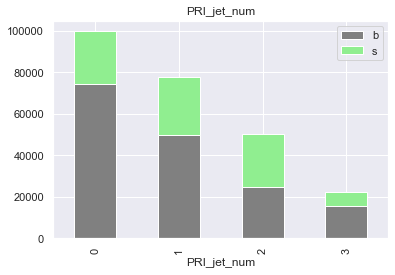

In [140]:
# Target(Label) vs Categorical (PRI_jet_num)
# Suplots of categorical features v price
sns.set_style('darkgrid')
plt.figure(figsize = (20,7))

PRI_jet_num = df.groupby(['PRI_jet_num','Label']).PRI_jet_num.count().unstack()
PRI_jet_num.plot(kind = 'bar', stacked = True, 
                   title = 'PRI_jet_num', 
                   color = ['grey','lightgreen','cyan', 'blue'])
plt.legend()
plt.show()

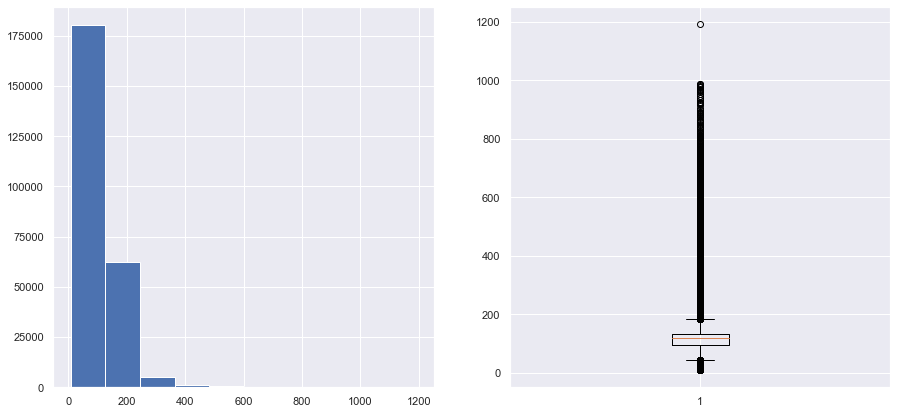

In [141]:
figs = plt.figure(figsize =(15,7))
ax1 = figs.add_subplot(121)
ax2 = figs.add_subplot(122)
x = df['DER_mass_MMC']
ax1.hist(x)
ax2.boxplot(x)
plt.show()

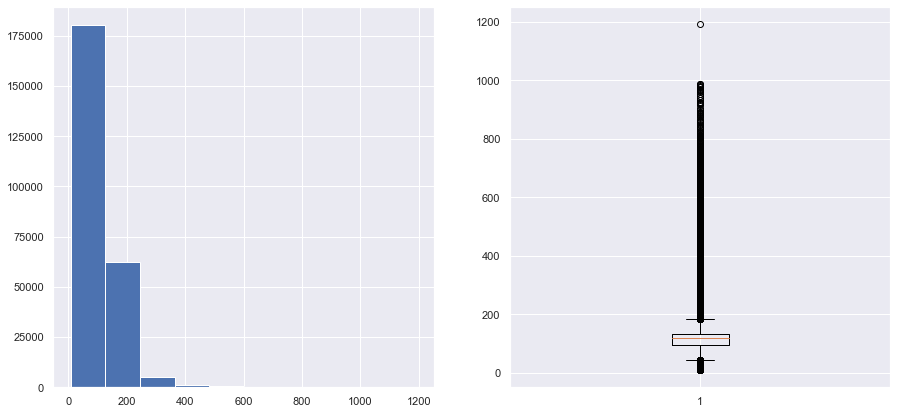

In [142]:
figs = plt.figure(figsize =(15,7))
ax1 = figs.add_subplot(121)
ax2 = figs.add_subplot(122)
x = df['DER_mass_MMC']
ax1.hist(x)
ax2.boxplot(x)
plt.show()

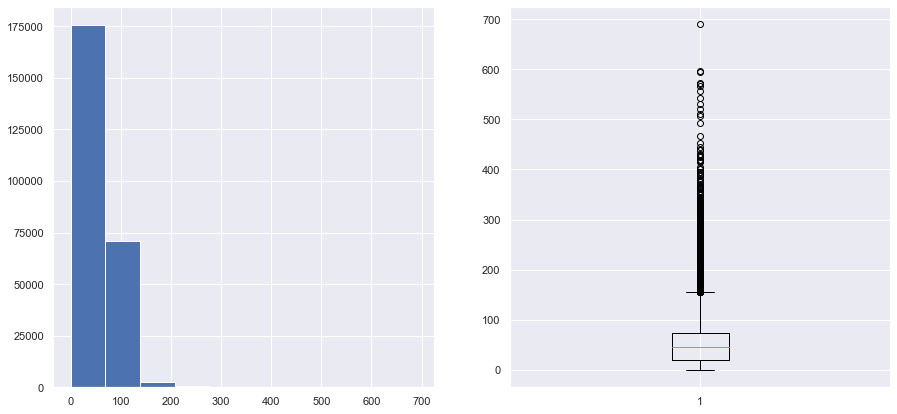

In [143]:
figs = plt.figure(figsize =(15,7))
ax1 = figs.add_subplot(121)
ax2 = figs.add_subplot(122)
x = df['DER_mass_transverse_met_lep']
ax1.hist(x)
ax2.boxplot(x)
plt.show()

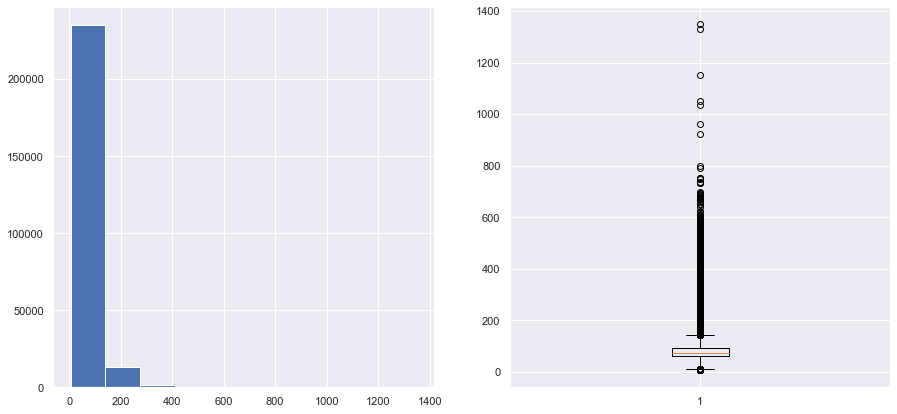

In [144]:
figs = plt.figure(figsize =(15,7))
ax1 = figs.add_subplot(121)
ax2 = figs.add_subplot(122)
x = df['DER_mass_vis']
ax1.hist(x)
ax2.boxplot(x)
plt.show()

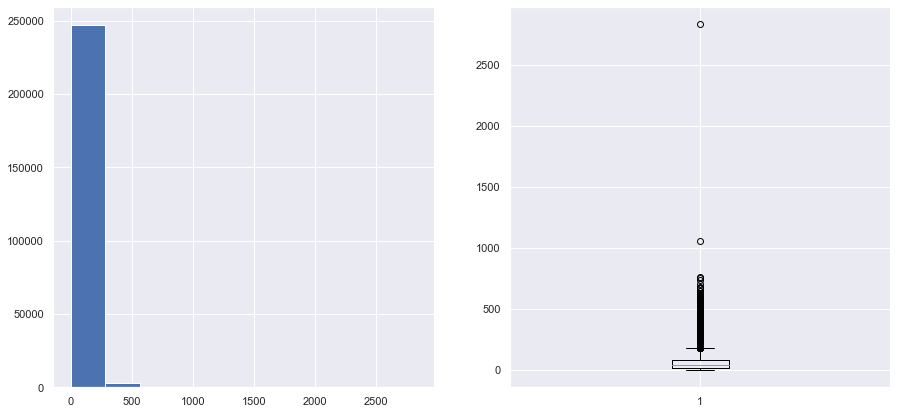

In [145]:
figs = plt.figure(figsize =(15,7))
ax1 = figs.add_subplot(121)
ax2 = figs.add_subplot(122)
x = df['DER_pt_h']
ax1.hist(x)
ax2.boxplot(x)
plt.show()           

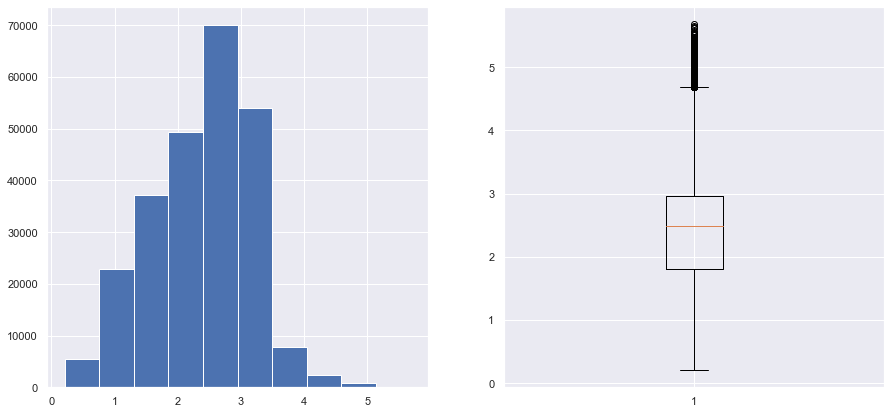

In [146]:
figs = plt.figure(figsize =(15,7))
ax1 = figs.add_subplot(121)
ax2 = figs.add_subplot(122)
x = df['DER_deltar_tau_lep']
ax1.hist(x)
ax2.boxplot(x)
plt.show()

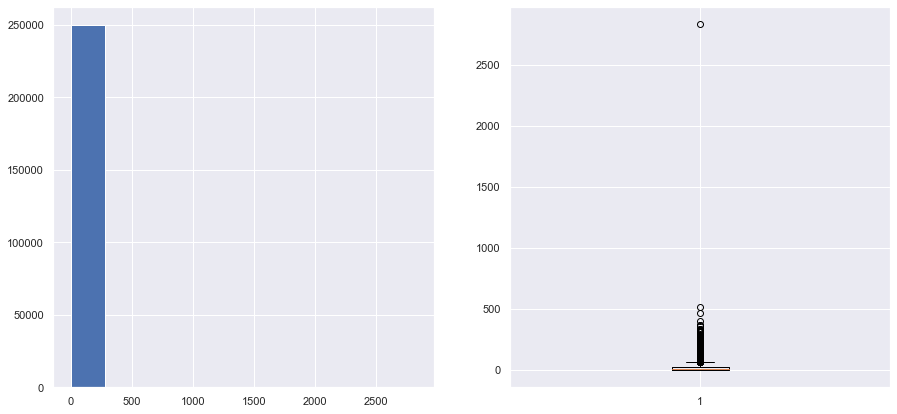

In [147]:
figs = plt.figure(figsize =(15,7))
ax1 = figs.add_subplot(121)
ax2 = figs.add_subplot(122)
x = df['DER_pt_tot']
ax1.hist(x)
ax2.boxplot(x)
plt.show()

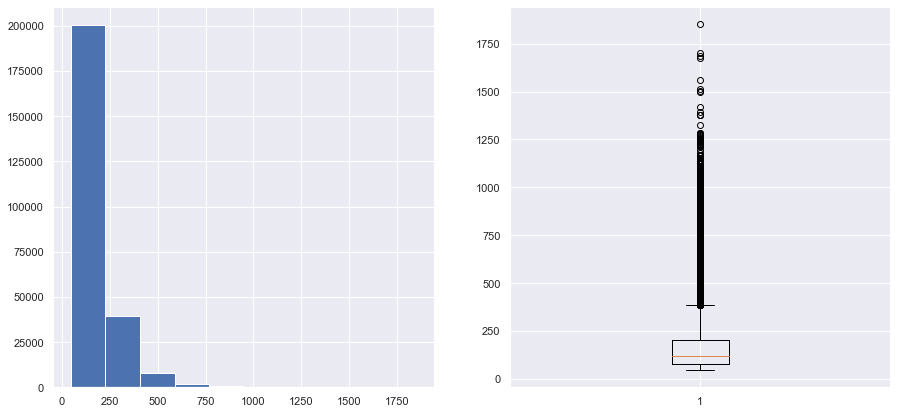

In [148]:
figs = plt.figure(figsize =(15,7))
ax1 = figs.add_subplot(121)
ax2 = figs.add_subplot(122)
x = df['DER_sum_pt']
ax1.hist(x)
ax2.boxplot(x)
plt.show()

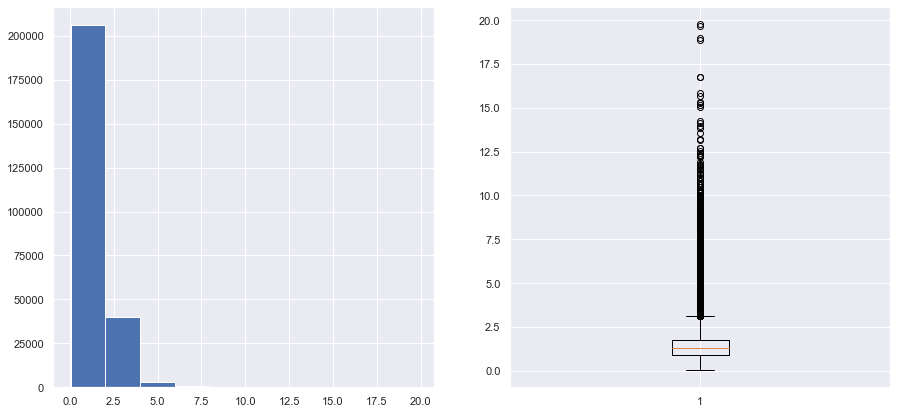

In [149]:
figs = plt.figure(figsize =(15,7))
ax1 = figs.add_subplot(121)
ax2 = figs.add_subplot(122)
x = df['DER_pt_ratio_lep_tau']
ax1.hist(x)
ax2.boxplot(x)
plt.show()

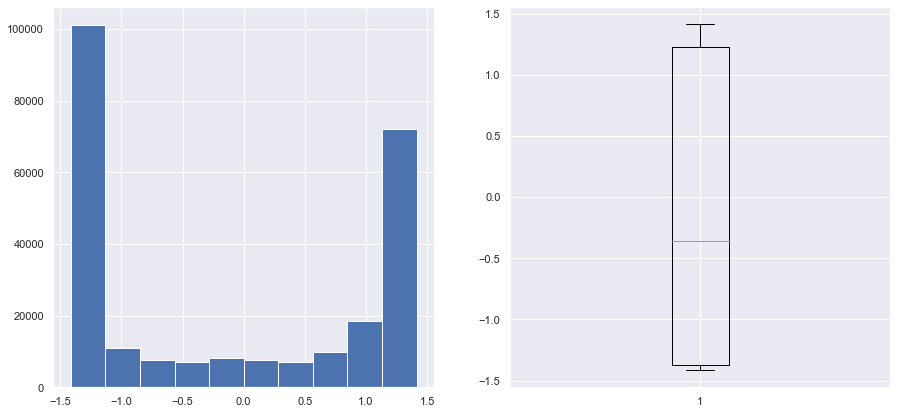

In [152]:
figs = plt.figure(figsize =(15,7))
ax1 = figs.add_subplot(121)
ax2 = figs.add_subplot(122)
x = df['DER_met_phi_centrality']
ax1.hist(x)
ax2.boxplot(x)
plt.show()

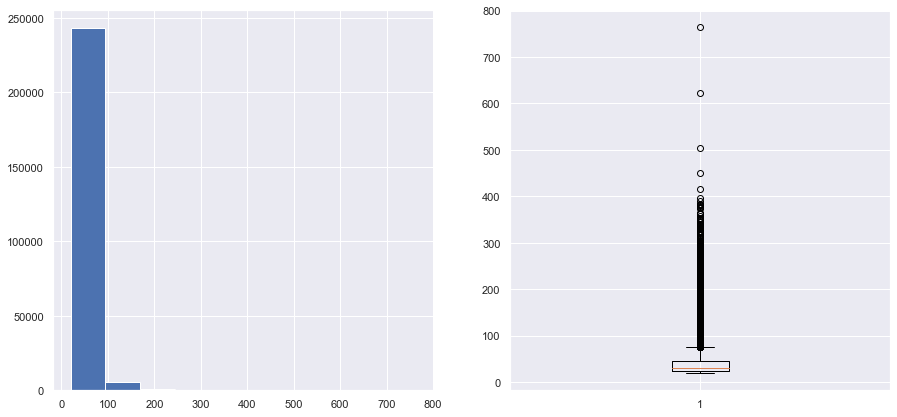

In [153]:
figs = plt.figure(figsize =(15,7))
ax1 = figs.add_subplot(121)
ax2 = figs.add_subplot(122)
x = df['PRI_tau_pt']
ax1.hist(x)
ax2.boxplot(x)
plt.show()

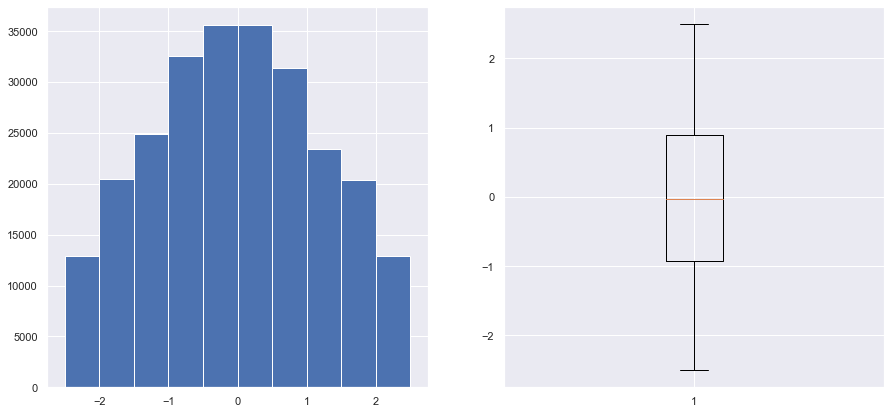

In [154]:
figs = plt.figure(figsize =(15,7))
ax1 = figs.add_subplot(121)
ax2 = figs.add_subplot(122)
x = df['PRI_tau_eta']
ax1.hist(x)
ax2.boxplot(x)
plt.show()

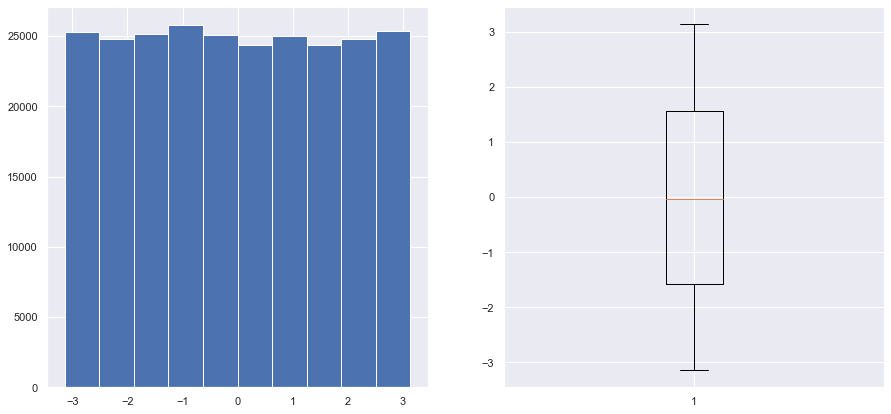

In [155]:
figs = plt.figure(figsize =(15,7))
ax1 = figs.add_subplot(121)
ax2 = figs.add_subplot(122)
x = df['PRI_tau_phi']
ax1.hist(x)
ax2.boxplot(x)
plt.show()

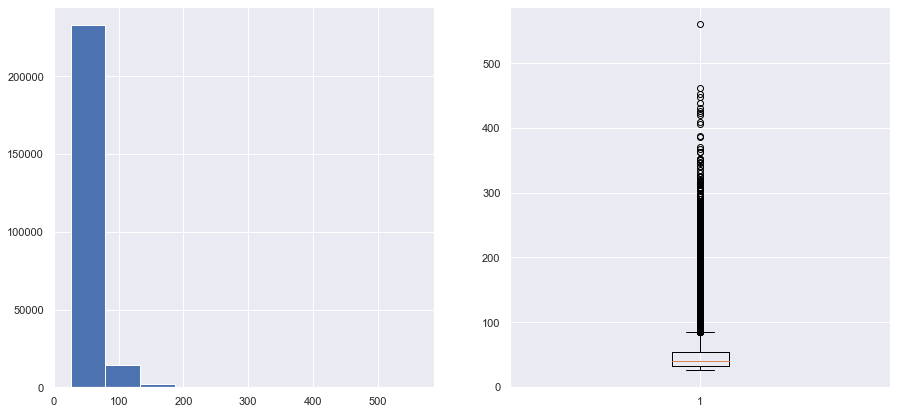

In [156]:
figs = plt.figure(figsize =(15,7))
ax1 = figs.add_subplot(121)
ax2 = figs.add_subplot(122)
x = df['PRI_lep_pt']
ax1.hist(x)
ax2.boxplot(x)
plt.show()

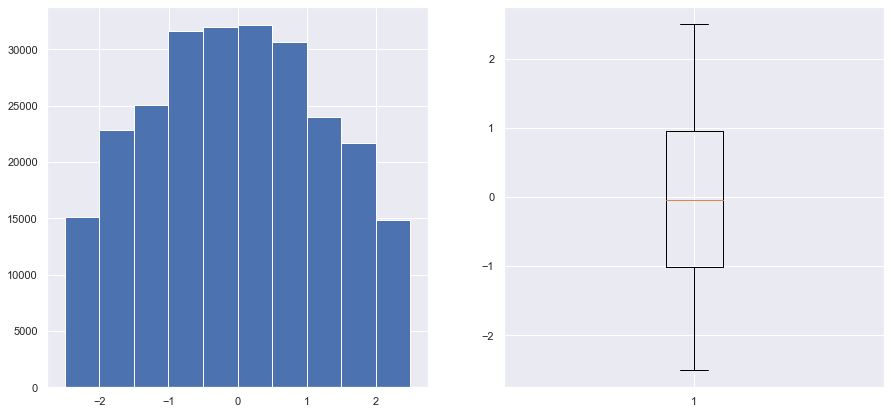

In [157]:
figs = plt.figure(figsize =(15,7))
ax1 = figs.add_subplot(121)
ax2 = figs.add_subplot(122)
x = df['PRI_lep_eta']
ax1.hist(x)
ax2.boxplot(x)
plt.show()

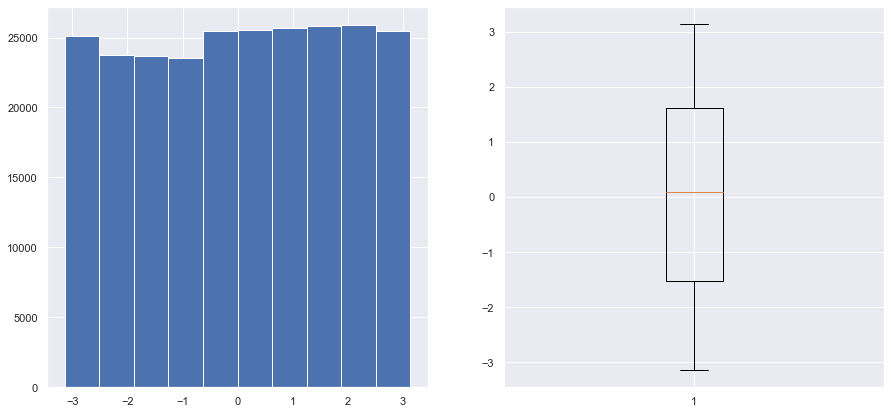

In [158]:
figs = plt.figure(figsize =(15,7))
ax1 = figs.add_subplot(121)
ax2 = figs.add_subplot(122)
x = df['PRI_lep_phi']
ax1.hist(x)
ax2.boxplot(x)
plt.show()

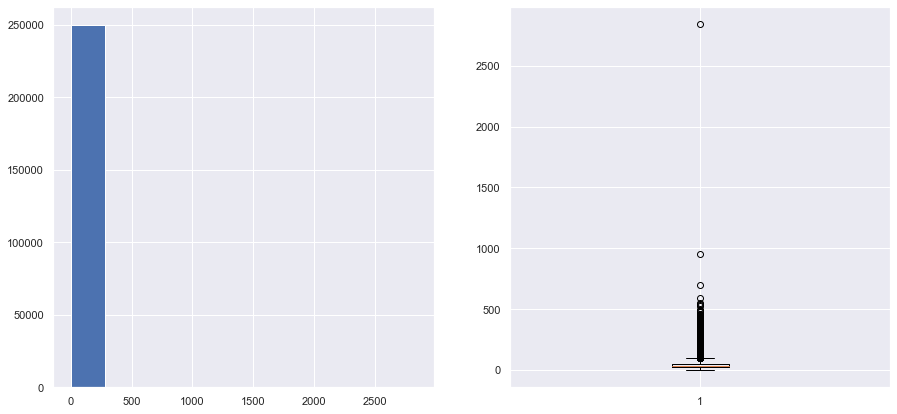

In [159]:
figs = plt.figure(figsize =(15,7))
ax1 = figs.add_subplot(121)
ax2 = figs.add_subplot(122)
x = df['PRI_met']
ax1.hist(x)
ax2.boxplot(x)
plt.show()

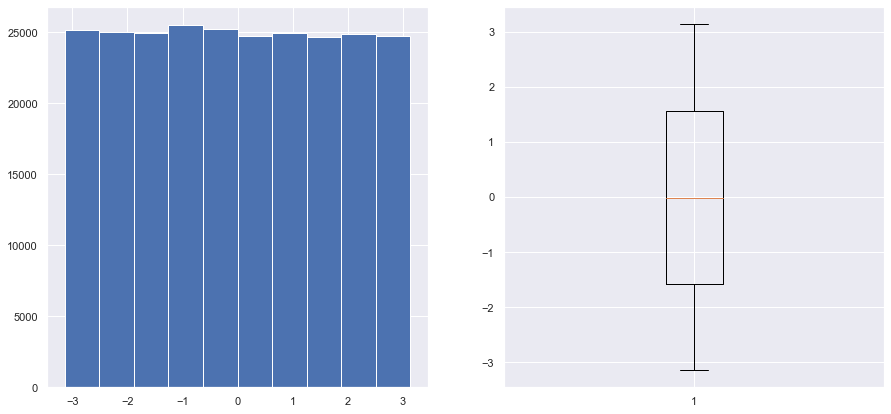

In [160]:
figs = plt.figure(figsize =(15,7))
ax1 = figs.add_subplot(121)
ax2 = figs.add_subplot(122)
x = df['PRI_met_phi']
ax1.hist(x)
ax2.boxplot(x)
plt.show()

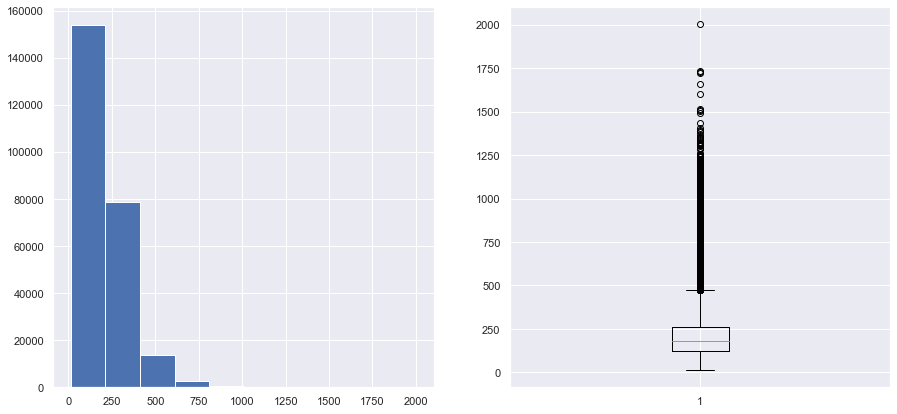

In [161]:
figs = plt.figure(figsize =(15,7))
ax1 = figs.add_subplot(121)
ax2 = figs.add_subplot(122)
x = df['PRI_met_sumet']
ax1.hist(x)
ax2.boxplot(x)
plt.show()

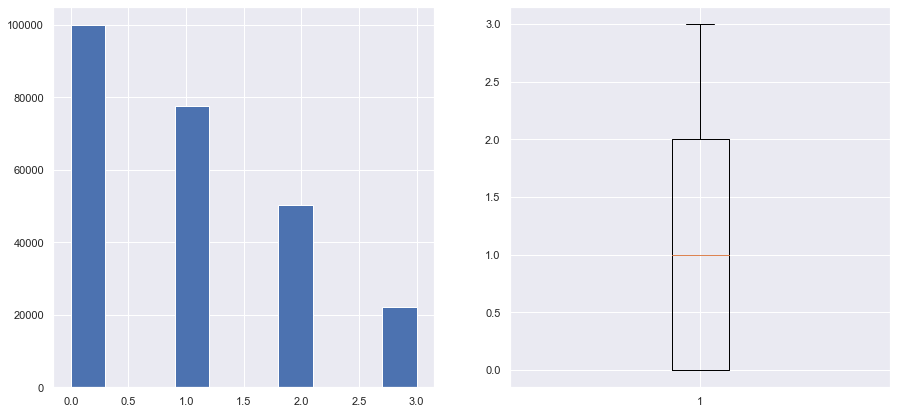

In [162]:
figs = plt.figure(figsize =(15,7))
ax1 = figs.add_subplot(121)
ax2 = figs.add_subplot(122)
x = df['PRI_jet_num']
ax1.hist(x)
ax2.boxplot(x)
plt.show()

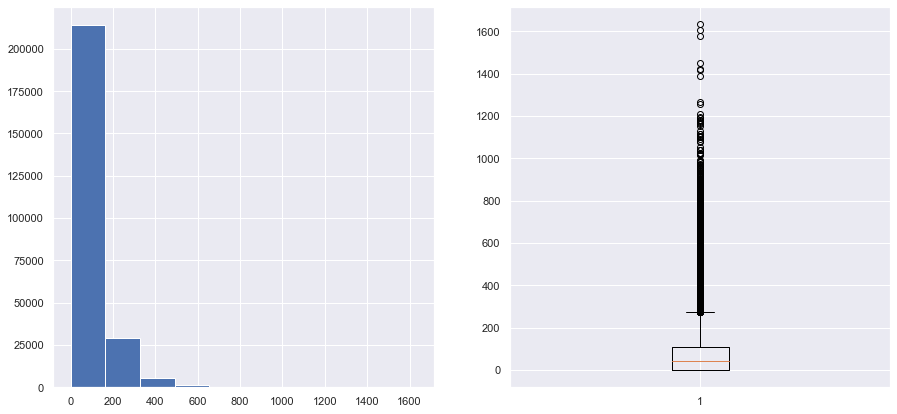

In [163]:
figs = plt.figure(figsize =(15,7))
ax1 = figs.add_subplot(121)
ax2 = figs.add_subplot(122)
x = df['PRI_jet_all_pt']
ax1.hist(x)
ax2.boxplot(x)
plt.show()

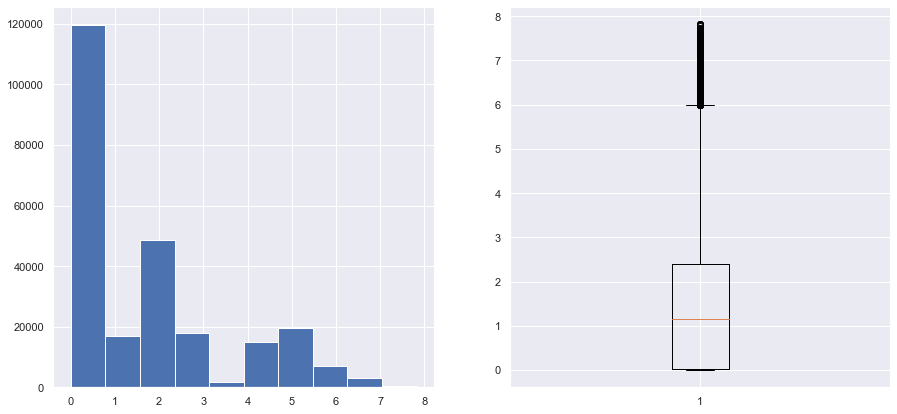

In [164]:
figs = plt.figure(figsize =(15,7))
ax1 = figs.add_subplot(121)
ax2 = figs.add_subplot(122)
x = df['Weight']
ax1.hist(x)
ax2.boxplot(x)
plt.show()

# Features Importance

In [165]:
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split

df_i = df.copy()

Xi = df.drop(labels=['Label'], axis =1)
Yi = df['Label']
Yi=Yi.replace({'s':1, 'b':0})
xi_train, xi_test, yi_train, yi_test = train_test_split(Xi, Yi, test_size = .20, random_state = 101)

In [166]:
rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select = 20)
xi_train_rfe = rfe.fit_transform(xi_train, yi_train)
xi_test_rfe = rfe.transform(xi_test)

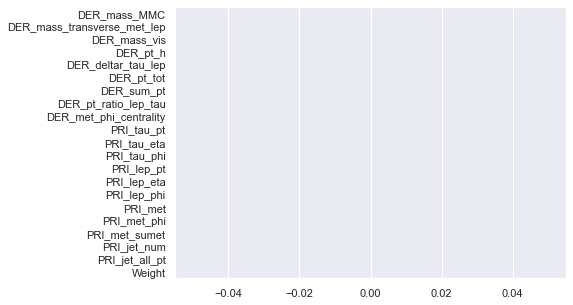

In [167]:
sns.set()
plt.figure(figsize=(7,5))
sns.barplot(y=xi_train.columns, x=max(rfe.ranking_)-rfe.ranking_)
plt.show()

In [168]:
selected_features_rfe = [col for i, col in enumerate(xi_train.columns) if rfe.support_[i]]
selected_features_rfe

['DER_mass_MMC',
 'DER_mass_transverse_met_lep',
 'DER_mass_vis',
 'DER_pt_h',
 'DER_deltar_tau_lep',
 'DER_pt_tot',
 'DER_sum_pt',
 'DER_pt_ratio_lep_tau',
 'DER_met_phi_centrality',
 'PRI_tau_pt',
 'PRI_tau_eta',
 'PRI_tau_phi',
 'PRI_lep_pt',
 'PRI_lep_eta',
 'PRI_lep_phi',
 'PRI_met',
 'PRI_met_phi',
 'PRI_met_sumet',
 'PRI_jet_num',
 'PRI_jet_all_pt',
 'Weight']

# Model building

## Train & test  dataset preparation

In [169]:
X = df.drop(labels=['Label','Weight'], axis = 1)
Y = df['Label']
Y = Y.replace({'s':1, 'b':0})

In [170]:
X.shape, Y.shape

((250000, 20), (250000,))

In [171]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = .20, random_state = 101)

## LogisticRegression

In [172]:
from sklearn.linear_model import LogisticRegression

lreg = LogisticRegression(max_iter = 200, verbose = 1)
lreg.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\kaush\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s finished


LogisticRegression(max_iter=200, verbose=1)

In [173]:
# Predict
y_pred_lreg = lreg.predict(x_test)

In [174]:
# Score It
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,f1_score, precision_score, recall_score

# Confusion Matrix
print('Logistic Regression')
print('\n')
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred_lreg))
print('--'*40)

# Classification Report
print('Classification Report')
print(classification_report(y_test,y_pred_lreg))

# Accuracy
print('--'*40)
logreg_accuracy = round(accuracy_score(y_test, y_pred_lreg) * 100,2)
print('Accuracy', logreg_accuracy,'%')

Logistic Regression


Confusion Matrix
[[27798  5034]
 [ 8315  8853]]
--------------------------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.77      0.85      0.81     32832
           1       0.64      0.52      0.57     17168

    accuracy                           0.73     50000
   macro avg       0.70      0.68      0.69     50000
weighted avg       0.72      0.73      0.73     50000

--------------------------------------------------------------------------------
Accuracy 73.3 %


## Linear Support Vector classifier

In [175]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(x_train, y_train)

SVC()

In [176]:
# Predict
y_pred_svc = svc.predict(x_test)

In [177]:
# Score It
print('Support Vector Classifier')
print('\n')
# Confusion matrix
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred_svc))
print('--'*40)

# Classification report
print('Classification Report')
print(classification_report(y_test, y_pred_svc))

# Accuracy
print('--'*40)
svc_accuracy = round(accuracy_score(y_test, y_pred_svc)*100,2)
print('Accuracy', svc_accuracy,'%')

Support Vector Classifier


Confusion Matrix
[[29266  3566]
 [ 5763 11405]]
--------------------------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.84      0.89      0.86     32832
           1       0.76      0.66      0.71     17168

    accuracy                           0.81     50000
   macro avg       0.80      0.78      0.79     50000
weighted avg       0.81      0.81      0.81     50000

--------------------------------------------------------------------------------
Accuracy 81.34 %


#### SVC parameter tuning with GridSearch : System stack have to try on colab 

In [178]:
# Create parameter grid
param_grid = {'C':[0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
             'kernel': ['rbf']}

In [179]:
# from sklearn.model_selection import GridSearchCV
# grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=1)
# grid.fit(x_train, y_train)

In [180]:
# #best_params and best_estimator
# print(grid.best_params_)
# print()
# print(grid.best_estimator_)


In [182]:
# Predict using best parameters
# y_pred_grid=grid.predict(x_test)

# # Score It
# #Consusion matrix
# print('Support Vector Classifierm with GridSearchCV')
# print('\n')
# # Confusion matrix
# print('Confusion Matrix')
# print(confusion_matrix(y_test, y_pred_grid))
# print('--'*40)
# 
# # Classification report
# print('Classification Report')
# print(classification_report(y_test, y_pred_grid))
# 
# # Accuracy
# print('--'*40)
# grid_accuracy = round(accuracy_score(y_test, y_pred_grid)*100,2)
# print('Accuracy', grid_accuracy,'%')

## Kernel support vector classifier

In [183]:
#Feature scalling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train_sc = sc.fit_transform(x_train)
x_test_sc = sc.transform(x_test)

In [184]:
from sklearn.svm import SVC
# Instantiate model object
ksvc = SVC(kernel='rbf', random_state=0)
ksvc.fit(x_train_sc, y_train)

SVC(random_state=0)

In [185]:
y_pred_ksvc = ksvc.predict(x_test_sc)

In [186]:
# Score
print('Kernel SVC')
print()
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred_ksvc))

#Classification Report
print('--'*40)
print('Classification Report')
print(classification_report(y_test, y_pred_ksvc))

#Accuarcy
print('--'*40)
ksvc_accuracy = round(accuracy_score(y_test, y_pred_ksvc)*100, 1)
print('Accuracy', ksvc_accuracy, '%')

Kernel SVC

Confusion Matrix
[[29425  3407]
 [ 5031 12137]]
--------------------------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.85      0.90      0.87     32832
           1       0.78      0.71      0.74     17168

    accuracy                           0.83     50000
   macro avg       0.82      0.80      0.81     50000
weighted avg       0.83      0.83      0.83     50000

--------------------------------------------------------------------------------
Accuracy 83.1 %


## K-Nearest Neighbors

In [187]:
df_k = df.copy()

In [188]:
X_k = df_k.drop(labels=['Label'], axis=1)
Y_k = df_k['Label']
Y_k=Y_k.replace({'s':1, 'b':0})

In [189]:
# Standardize the Variables
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_k)
scaled_features = scaler.transform(X_k)
scaled_features

array([[ 3.14910656e-01,  6.83319669e-02,  4.07680272e-01, ...,
         1.04440205e+00,  4.12510497e-01, -8.76814257e-01],
       [ 7.40827026e-01,  5.52504823e-01,  5.40136414e-01, ...,
         2.13049736e-02, -2.73819964e-01,  3.12952525e-01],
       [-2.96341266e-14,  3.19515553e+00,  1.09655998e+00, ...,
         2.13049736e-02, -2.93969845e-01,  3.73645012e-01],
       ...,
       [-3.10930673e-01,  3.19316447e-01, -1.30863670e-01, ...,
         2.13049736e-02, -3.17017229e-01, -8.68290547e-01],
       [-5.10097335e-01, -8.45323970e-01, -3.02973380e-01, ...,
        -1.00179211e+00, -7.45439413e-01,  1.85825327e-02],
       [-2.96341266e-14,  6.65336083e-01, -2.53522760e-01, ...,
        -1.00179211e+00, -7.45439413e-01,  1.23036916e-01]])

In [190]:
# Use scaled features variable to re-create a feature dataframe
feature_df = pd.DataFrame(scaled_features, columns=X_k.columns)
xk_train, xk_test, yk_train, yk_test = train_test_split(feature_df, Y_k, test_size = .20, random_state = 101)

In [191]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(xk_train, yk_train)

KNeighborsClassifier(n_neighbors=1)

In [192]:
y_pred_knn = knn.predict(xk_test)

In [193]:
# Score
print('KNN')
print()
print('Confusion Matrix')
print(confusion_matrix(yk_test, y_pred_knn))

#Classification Report
print('--'*40)
print('Classification Report')
print(classification_report(yk_test, y_pred_knn))

#Accuarcy
print('--'*40)
knn_accuracy = round(accuracy_score(yk_test, y_pred_knn)*100, 1)
print('Accuracy', knn_accuracy, '%')

KNN

Confusion Matrix
[[29488  3344]
 [ 2617 14551]]
--------------------------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.92      0.90      0.91     32832
           1       0.81      0.85      0.83     17168

    accuracy                           0.88     50000
   macro avg       0.87      0.87      0.87     50000
weighted avg       0.88      0.88      0.88     50000

--------------------------------------------------------------------------------
Accuracy 88.1 %


## KNN Parameter Tuning

In [194]:
error_rate=[]

for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(xk_train, yk_train)
    pred_i = knn.predict(xk_test)
    error_rate.append(np.mean(pred_i != yk_test))

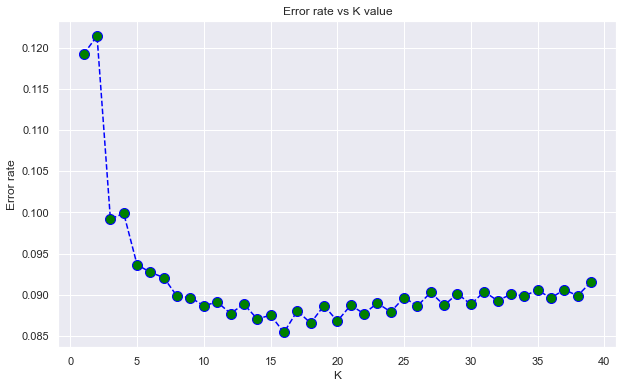

In [195]:
# plot error rate
plt.figure(figsize=(10,6))
plt.plot(range(1,40), error_rate, color='blue', linestyle='--', marker ='o',
        markerfacecolor ='green', markersize=10)
plt.title('Error rate vs K value')
plt.xlabel('K')
plt.ylabel('Error rate')
plt.show()

In [196]:
# k = 16 is optimal value for k
knn = KNeighborsClassifier(n_neighbors = 16)
#knn = KNeighborsClassifier(n_neighbors = 18) # 18
knn.fit(xk_train, yk_train)

KNeighborsClassifier(n_neighbors=16)

In [197]:
y_pred_knn_op = knn.predict(xk_test)

In [198]:
# score with new KNN
# Score
print('KNN')
print()
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred_knn_op))

#Classification Report
print('--'*40)
print('Classification Report')
print(classification_report(y_test, y_pred_knn_op))

#Accuarcy
print('--'*40)
knn_accuracy = round(accuracy_score(y_test, y_pred_knn_op)*100, 1)
print('Accuracy', knn_accuracy, '%')

KNN

Confusion Matrix
[[30357  2475]
 [ 1797 15371]]
--------------------------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.94      0.92      0.93     32832
           1       0.86      0.90      0.88     17168

    accuracy                           0.91     50000
   macro avg       0.90      0.91      0.91     50000
weighted avg       0.92      0.91      0.91     50000

--------------------------------------------------------------------------------
Accuracy 91.5 %


## Saving best model:

### Approach 1 : Pickle approach

In [206]:
import pickle

In [207]:
# saving knn model
Pkl_Filename = "best_knn_higgsBosson6oct.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(knn, file)

In [208]:
with open(Pkl_Filename, 'rb') as file:  
    Pickled_LR_Model = pickle.load(file)

In [209]:
# loading and Testing
with open(Pkl_Filename, 'rb') as file:  
    knnp = pickle.load(file)
y_pred_knn_op = knnp.predict(xk_test)

# score with new KNN
# Score
print('KNN')
print()
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred_knn_op))

#Classification Report
print('--'*40)
print('Classification Report')
print(classification_report(y_test, y_pred_knn_op))

#Accuarcy
print('--'*40)
knn_accuracy = round(accuracy_score(y_test, y_pred_knn_op)*100, 1)
print('Accuracy', knn_accuracy, '%')

KNN

Confusion Matrix
[[30357  2475]
 [ 1797 15371]]
--------------------------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.94      0.92      0.93     32832
           1       0.86      0.90      0.88     17168

    accuracy                           0.91     50000
   macro avg       0.90      0.91      0.91     50000
weighted avg       0.92      0.91      0.91     50000

--------------------------------------------------------------------------------
Accuracy 91.5 %


### Approach 2 : Joblib  approach

In [212]:
import joblib

In [213]:
# saving model
joblib_file = "joblib_best_knn_higgsBosson6oct.pkl"  
joblib.dump(knn, joblib_file)

['joblib_best_knn_higgsBosson6oct.pkl']

In [215]:
# loading  and testing model
knnj = joblib.load(joblib_file)

y_pred_knn_op = knnj.predict(xk_test)

# score with new KNN
# Score
print('KNN')
print()
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred_knn_op))

#Classification Report
print('--'*40)
print('Classification Report')
print(classification_report(y_test, y_pred_knn_op))

#Accuarcy
print('--'*40)
knn_accuracy = round(accuracy_score(y_test, y_pred_knn_op)*100, 1)
print('Accuracy', knn_accuracy, '%')

KNN

Confusion Matrix
[[30357  2475]
 [ 1797 15371]]
--------------------------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.94      0.92      0.93     32832
           1       0.86      0.90      0.88     17168

    accuracy                           0.91     50000
   macro avg       0.90      0.91      0.91     50000
weighted avg       0.92      0.91      0.91     50000

--------------------------------------------------------------------------------
Accuracy 91.5 %


# DecisonTree classifier

In [199]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()
dtree.fit(x_train, y_train)

DecisionTreeClassifier()

In [200]:
y_pred_dtree = dtree.predict(x_test)

In [201]:
# score with new DecisionTree
# Score
print('DecisionTree')
print()
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred_dtree))

#Classification Report
print('--'*40)
print('Classification Report')
print(classification_report(y_test, y_pred_dtree))

#Accuarcy
print('--'*40)
dt_accuracy = round(accuracy_score(y_test, y_pred_dtree)*100, 1)
print('Accuracy', dt_accuracy, '%')

DecisionTree

Confusion Matrix
[[26744  6088]
 [ 6007 11161]]
--------------------------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.82      0.81      0.82     32832
           1       0.65      0.65      0.65     17168

    accuracy                           0.76     50000
   macro avg       0.73      0.73      0.73     50000
weighted avg       0.76      0.76      0.76     50000

--------------------------------------------------------------------------------
Accuracy 75.8 %


# RandomForestClassifier

In [202]:
#x_train.drop(columns=['Weight'], axis=1, inplace=True)
#x_train.reset_index(drop = True, inplace = True)

In [203]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(x_train, y_train)

RandomForestClassifier(n_estimators=200)

In [204]:
y_pred_rfc = rfc.predict(x_test)

In [205]:
# score with new RandomForestClassifier
# Score
print('RandomForestClassifier')
print()
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred_rfc))

#Classification Report
print('--'*40)
print('Classification Report')
print(classification_report(y_test, y_pred_rfc))

#Accuarcy
print('--'*40)
dt_accuracy = round(accuracy_score(y_test, y_pred_rfc)*100, 1)
print('Accuracy', dt_accuracy, '%')

RandomForestClassifier

Confusion Matrix
[[29588  3244]
 [ 5097 12071]]
--------------------------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.85      0.90      0.88     32832
           1       0.79      0.70      0.74     17168

    accuracy                           0.83     50000
   macro avg       0.82      0.80      0.81     50000
weighted avg       0.83      0.83      0.83     50000

--------------------------------------------------------------------------------
Accuracy 83.3 %


In [216]:
!dir

 Volume in drive C is OS
 Volume Serial Number is F85F-3294

 Directory of C:\Users\kaush\NPTEL DataAnalyticsUsingPython

10/06/2021  06:46 PM    <DIR>          .
10/06/2021  06:46 PM    <DIR>          ..
09/29/2021  11:07 AM    <DIR>          .ipynb_checkpoints
09/03/2021  02:28 PM             9,753 acad.xlsx
03/18/2021  01:40 PM             8,724 anova1.xlsx
09/09/2021  12:13 PM         3,849,753 Autoviz_and_dabl.ipynb
10/06/2021  06:27 PM        34,400,726 best_knn_higgsBosson6oct.pkl
09/08/2021  03:45 PM             8,702 CART.xlsx
09/06/2021  05:39 PM             8,200 Clustering_ex.xlsx
09/09/2021  12:14 PM             4,145 Dabl.ipynb
09/10/2021  01:38 PM           529,498 Data analytics using python week 6-7.ipynb
09/06/2021  06:36 PM             8,165 datapoints.xlsx
08/28/2021  11:06 AM             8,396 dummy.xlsx
08/28/2021  11:24 AM             9,395 dummy2.xlsx
09/08/2021  03:45 PM             8,424 hierarchical_clustering.xlsx
10/06/2021  06:46 PM           967,982 Higgs